In [1]:
# 3D FNO Naiver Stoke 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utilities3 import *
import os
import operator
import glob
import re
from functools import reduce
from functools import partial
import pandas as pd
from timeit import default_timer
from Adam import Adam
torch.manual_seed(0)
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

In [2]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3 # only difference compare to 2S is adding another dimension of array

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        
input shape: (batchsize, x=64, y=64, t=40, c=13)
        
output: the solution of the next 40 timesteps
                
output shape: (batchsize, x=64, y=64, t=40, c=1)

In [3]:
ntest = 200
modes = 8
width = 20
batch_size = 10
batch_size2 = batch_size
epochs = 500
epochs = 50

learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5
print(epochs, learning_rate, scheduler_step, scheduler_gamma)

runtime = np.zeros(2, )
t1 = default_timer()
sub = 1
# S = 64 // sub
# S = 40 // sub
S = 32 // sub

T_in = 10 # number of time steps input
T = 40    # number of time steps output

50 0.001 100 0.5


In [4]:
# Do not execute this cell if running with built-in datasets
ntrain = 10
final = []
j =0
# spatial = np.empty((64,64))
# spatial = np.empty((40,40))
spatial = np.empty((32,32))
spatial = spatial[:,:,np.newaxis]
solution = np.empty((64,64))
solution = solution[:,:,np.newaxis]
velocity_profile_dir_2 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_eight/velocity_profile/velocity_profile*'
velocity_profile_dir_3 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_eight/velocity_profile/velocity_profile_'
# velocity_profile_dir_2 = 'C:\\Users\\Kevin\\Desktop\\courses\\Master-Data-Spreadsheet\\data\\velocity_profile\\*'
# velocity_profile_dir_3 = 'C:\\Users\\Kevin\\Desktop\\courses\\Master-Data-Spreadsheet\\data\\velocity_profile\\velocity_profile_'
time_steps = sorted(list(set(["".join(re.findall(r'[0-9]*',item)) for item in glob.glob(velocity_profile_dir_2)])))
for time_step in time_steps:
    a = pd.read_csv( velocity_profile_dir_3 + str(time_step) + '.prof')
    # x_axis = a.iloc[1:532,:].reset_index(drop=True)
    x_axis = a.iloc[1:545,:].reset_index(drop=True)
    x_axis.columns =["x_axis"]
    # y_axis = a.iloc[534:1065,:].reset_index(drop=True)
    y_axis = a.iloc[547:1091,:].reset_index(drop=True)
    y_axis.columns =["y_axis"]
    # z_axis = a.iloc[1067:1598,:].reset_index(drop=True)
    z_axis = a.iloc[1093:1637,:].reset_index(drop=True)
    z_axis.columns =["z_axis"]
    # y_velocity = a.iloc[1600:-2,:].reset_index(drop=True)
    y_velocity = a.iloc[1639:-2,:].reset_index(drop=True)
    x_velocity = y_velocity.copy()
    x_velocity.columns =["x_velocity"]
    y_velocity.columns =["y_velocity"]
    temp = pd.concat([x_axis,y_axis,z_axis,x_velocity,y_velocity],axis=1)
    temp2 = temp.copy()
   # print(temp2.shape)
    temp = temp.iloc[:512,:]
    # temp1=temp.copy()
    # for i in range(2):
    #     temp = pd.concat([temp,temp1],axis=0)
    temp4 =temp.copy()    
   # print(temp.shape)    
    temp3 = temp.copy()    
    #spatial_temp  = temp4[["x_axis","y_axis"]].values.reshape(64,64) #can be reshaped because 2048x2 => 64x64
    spatial_temp  = temp4[["x_axis","y_axis"]].values.reshape(32,32) #can be reshaped because 2048x2 => 64x64
    spatial_temp = spatial_temp[:,:,np.newaxis]
    spatial = np.concatenate((spatial,spatial_temp),axis=2) #axis is determine which side you wanna concatenate
    j = j+1
    if j == 9:  # stop at 9 time steps
        break
spatial_1  = spatial[np.newaxis,:,:,:] 
for i in range(5):
    spatial_final  = np.concatenate((spatial_1,spatial_1,spatial_1,spatial_1,spatial_1,spatial_1,spatial_1,spatial_1,spatial_1,spatial_1),axis=0)
spatial_final = spatial_final.astype(np.float32)
spatial_final = torch.from_numpy(spatial_final)
train_a = spatial_final

In [5]:
spatial_final.shape

torch.Size([10, 32, 32, 10])

input: 

solution u, x, y, t (z), why there is extra dimension??

the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.


In [6]:
#solution = np.empty((64,64))
# solution = np.empty((40,40))
solution = np.empty((32,32))


j=0
solution = solution[:,:,np.newaxis]
solution_final = np.empty((1,64,64,1))
velocity_profile_dir_2 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_eight/velocity_profile/velocity_profile*'
velocity_profile_dir_3 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_eight/velocity_profile/velocity_profile_'
time_steps = sorted(list(set(["".join(re.findall(r'[0-9]*',item)) for item in glob.glob(velocity_profile_dir_2)])))
for time_step in time_steps:
    a = pd.read_csv( velocity_profile_dir_3 + str(time_step) + '.prof')
    x_axis = a.iloc[1:545,:].reset_index(drop=True)
    x_axis.columns =["x_axis"]
    y_axis = a.iloc[547:1091,:].reset_index(drop=True)
    y_axis.columns =["y_axis"]
    z_axis = a.iloc[1093:1637,:].reset_index(drop=True)
    z_axis.columns =["z_axis"]    
    y_velocity = a.iloc[1639:-2,:].reset_index(drop=True)
    x_velocity = y_velocity.copy()
    x_velocity.columns =["x_velocity"]
    y_velocity.columns =["y_velocity"]
    temp = pd.concat([x_axis,y_axis,z_axis,x_velocity,y_velocity],axis=1)
    # temp = temp.iloc[:512,:]
    # temp = temp.iloc[:400,:]
    temp = temp.iloc[:512,:]
    temp1=temp.copy()
    # for i in range(1): #range(3)
    #     temp = pd.concat([temp,temp1],axis=0)
    # solution_temp = temp[["x_velocity","y_velocity"]].values.reshape(64,64)
    solution_temp = temp[["x_velocity","y_velocity"]].values.reshape(32,32)    
    solution_temp = solution_temp[:,:,np.newaxis]
    solution = np.concatenate((solution,spatial_temp),axis=2)
    # solution_1 = solution[np.newaxis,:,:,:]
    # solution_final = np.concatenate((solution_final,spatial_1),axis=0)
    # break
    j = j+1
    if j == 39:
        break
solution_1  = solution[np.newaxis,:,:,:] 
for i in range(5):
    solution_final  = np.concatenate((solution_1,solution_1,solution_1,solution_1,solution_1,solution_1,solution_1,solution_1,solution_1,solution_1),axis=0)
solution_final = solution_final.astype(np.float32)
solution_final = torch.from_numpy(solution_final)
train_u = solution_final

In [7]:
solution_final.shape

torch.Size([10, 32, 32, 40])

In [8]:
a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)

In [9]:
# # velocity 0.00002 of axis at time 0
# velocity_profile_dir_1 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_five/velocity_profile/'
# file_name_list = []
# velocity_temp = pd.DataFrame({"x_axis":[""],"y_velocity":[""]})

# for root, dirs, files in os.walk(velocity_profile_dir_1, topdown = True):
#     for filename in files:
#         file_name_list.append(os.path.join(root, filename))
# file_name_list = file_name_list[1:]   
# for file in file_name_list:
#     temp = pd.read_csv(file,skiprows=4)
#     temp.columns=['x_axis','y_velocity']
#     velocity_temp = pd.concat([velocity_temp,temp],axis=0).reset_index(drop=True)
# velocity_00002_step = velocity_temp.drop(0)     
# x_axis = velocity_00002_step['x_axis'].values
# x_axis = x_axis.astype(float) 
# x_axis = torch.from_numpy(x_axis).float().reshape(-1,100,1)
# y_velocity = velocity_00002_step['y_velocity'].values
# y_velocity = y_velocity.astype(float) 
# y_velocity = torch.from_numpy(y_velocity).float().reshape(-1,100)

# x_train  = x_axis        # x-axis value 
# y_train  = y_velocity    # y-velocity


# x_axis_test = velocity_00002_step['x_axis'].values
# x_axis_test = x_axis_test.astype(float) 
# x_axis_test = torch.from_numpy(x_axis_test).float().reshape(-1,100,1)
# y_velocity_test = velocity_00002_step['y_velocity'].values
# y_velocity_test = y_velocity_test.astype(float) 
# y_velocity_test = torch.from_numpy(y_velocity_test).float().reshape(-1,100)

# x_test = x_axis_test
# y_test = y_velocity_test


In [10]:
# # velocity 0.0009 of axis at time 900 time steps
# velocity_profile_dir_2 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_five/velocity_profile_one/velocity_profile'
# file_name_list = []
# velocity_temp = pd.DataFrame({"x_axis":[""],"y_velocity":[""]})

# for root, dirs, files in os.walk(velocity_profile_dir_2, topdown = True):
#     for filename in files:
#         file_name_list.append(os.path.join(root, filename)) #
# file_name_list = file_name_list[1:]   
# for file in file_name_list:
#     temp = pd.read_csv(file,skiprows=4)
#     temp.columns=['x_axis','y_velocity']
#     velocity_temp = pd.concat([velocity_temp,temp],axis=0).reset_index(drop=True)

# velocity_0009_step = velocity_temp.drop(0)       

# # x_axis = velocity_0009_step['x_axis'].values
# # x_axis = x_axis.astype(float) 
# # x_axis = torch.from_numpy(x_axis).float().reshape(-1,100,1)
# # y_velocity = velocity_0009_step['y_velocity'].values
# # y_velocity = y_velocity.astype(float) 
# # y_velocity = torch.from_numpy(y_velocity).float().reshape(-1,100)


# x_axis_test = velocity_0009_step['x_axis'].values
# x_axis_test = x_axis_test.astype(float) 
# x_axis_test = torch.from_numpy(x_axis_test).float().reshape(-1,100,1)
# y_velocity_test = velocity_0009_step['y_velocity'].values
# y_velocity_test = y_velocity_test.astype(float) 
# y_velocity_test = torch.from_numpy(y_velocity_test).float().reshape(-1,100)

# # x_train  = x_axis
# # y_train  = y_velocity
# x_test = x_axis_test
# y_test = y_velocity_test


input shape: (batchsize, x=64, y=64, t=40, c=13)
output: the solution of the next 40 timesteps
output shape: (batchsize, x=64, y=64, t=40, c=1)

NavierStokes_V1e-3_N5000_T50.mat contains the dataset for the 2D Navier-Stokes equation. It is of the shape [5000, 64, 64, 50], meaning it has 5000 training samples on a grid of (64, 64) with 50 time steps.

In [11]:
test_a = train_a
test_u =train_u

In [12]:
train_mse_list = []
train_l2_list  = []
test_l2_list   = []

model = FNO3d(modes, modes, modes, width)
print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
myloss = LpLoss(size_average=False)
# y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        # x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        out = model(x).view(batch_size, S, S, T)
        mse = F.mse_loss(out, y, reduction='mean')
        train_mse_list.append(mse.detach().numpy())
        #mse.backward(retain_graph=True) # only can use one backward, otherwise, the graph does not work
        y = y_normalizer.decode(y)  
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        train_l2_list.append(train_l2)
        print(ep)
    scheduler.step()
    model.eval()
    test_l2 = 0.0
pred = torch.zeros(test_u.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        # x, y = x.cuda(), y.cuda()
        # out = model(x)
        out = model(x).view(1, S, S, T)
        
        out = y_normalizer.decode(out)
        pred[index] = out
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_l2_list.append(test_l2)
        print(index, test_l2)
        index = index + 1    

6558537
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0 152.5610809326172
1 152.5610809326172
2 152.5610809326172
3 152.5610809326172
4 152.5610809326172
5 152.5610809326172
6 152.5610809326172
7 152.5610809326172
8 152.5610809326172
9 152.5610809326172


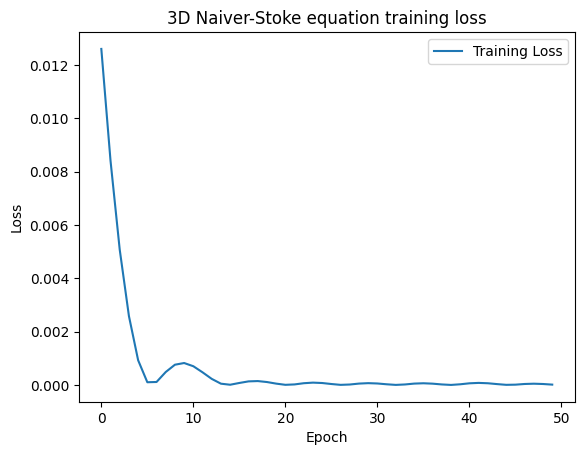

In [13]:
plt.plot(train_mse_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("3D Naiver-Stoke equation training loss")
plt.show()

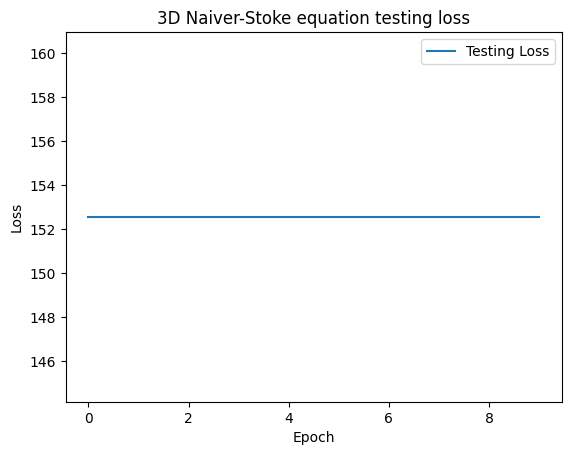

In [14]:
plt.plot(test_l2_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("3D Naiver-Stoke equation testing loss")
plt.legend()
plt.show()